In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
from pyshtools import spectralanalysis as spec
import pandas as pd
import sys
import cartopy.crs as ccrs
sys.path.insert(0,'/home/claire/Works/exo-top/')
from john_scripts.venus_topo_stats import RMS_from_l_powerspectrum, read_coeffs, plot_Venus 
from john_scripts.hoggard import read_hoggard
from exotop.asharms import powerspectrum_RMS
from exotop.useful_and_bespoke import minmaxnorm
from exotop.postaspect.aspect_scalings import fit_log
import h5py
import numpy.fft as fft
from matplotlib import mlab
from matplotlib import ticker
from collections import Counter
from itertools import groupby

In [41]:
def read_hdf(path='', fname='', key='data'):
    f = h5py.File(path+fname,"r")
    h=f[key]
    lat=f['lat']
    lon=f['long']
    print('h_data', np.shape(h))
    print('lat', np.shape(lat))
    print('lon', np.shape(lon))
    for item in h.attrs.items():
        print(item)
    
    return np.array(lat).squeeze(), np.array(lon).squeeze(), h

In [78]:
datapath = '/home/claire/Documents/science-docs/planet-data-misc/landais-synthetic/S01/'
lat, lon, h = read_hdf(path=datapath, fname='S01_A20_C05_H07_LAT5000_LON10000TOPO.hdf5')
R = h.attrs['radius']
C1 = h.attrs['C1']
alpha = h.attrs['alpha']

# scale for better FT
R = np.array(R)/1000
h = np.array(h)/1000

print('R =', R[0], 'm')
# assume radius and h have same units...

print('h min', np.min(h), 'max', np.max(h), 'm')

h_data (5000, 10000)
lat (5000, 1)
lon (10000, 1)
('C1', array([0.05]))
('H', array([0.7]))
('alpha', array([2.]))
('radius', array([10000.]))
('seed', b'01')
R = 10.0 m
h min -0.5223880339849188 max 1.6666666666666667 m


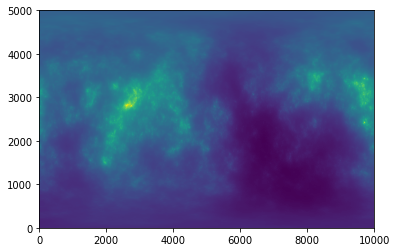

In [133]:
plt.pcolormesh(h)

In [109]:
def MPS(lat, lon, h, R, lon_res=20):
    # mean power spectrum

    n_samples = len(lat)
    
    # calculate appropriate Fs (samples per metre (assuming h in metres??))
    arc_length = 2*np.pi*R/2  # half circumference assuming sphere should be fine 
    samples_per_m = n_samples/arc_length
    print('samples per m', samples_per_m)
    
    lat_m = minmaxnorm(lat, a=0, b=arc_length)  # convert latitude to m from first measurement
    
    ts = lat_m[1] - lat_m[0] #-- distance between samples
    fs = int(1.0 / ts)          #-- Sampling frequency
    print('sampling frequency', fs)
    
    S_i = []
    for i in range(0, len(lon), lon_res):

        # take vertical N-S transects after Landais 2019
        hi = h[:,i]

        # take fft to get power spectral density - linear detrend like Gagnon
        power, freqs = mlab.psd(hi, Fs=fs, NFFT=fs, detrend='linear', noverlap=0, scale_by_freq=True)
        S_i.append(power)
        
    # average over frequency axis
    S_i = np.array(S_i)
    S = np.mean(S_i, axis=0)
    return S, freqs

def plot_MPS(S, k, fmt='kx'):
    def forward(x):
        return 1 / x

    def inverse(x):
        return 1 / x

    plt.plot(k, S, fmt, label='calculated')
    fig = plt.gcf()
    ax = plt.gca()
    ax.loglog()
    ax.set_xlabel('k (cycles/m)')
    ax.set_ylabel('E(k) (m$^3$)')
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#     ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    
    secax = ax.secondary_xaxis('top', functions=(forward, inverse))
    secax.set_xlabel('$\lambda$ (m)')
    return fig, ax

samples per m [159.15494309]
sampling frequency 159


/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


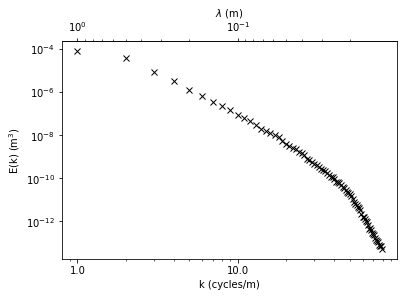

In [110]:
S, k = MPS(lat, lon, h, R, lon_res=200)
fig, ax = plot_MPS(S, k)

In [107]:
def K(q, alpha, C1):
    return C1/(alpha - 1) * (q**alpha - q)

def fit_slope(S, k, k_max=None, fig=None, ax=None, i_min=1, i_max=-1, fmt='g-', **kwargs):
    
    # find k max
    if k_max is not None and (k_max < np.max(k)):
        i_max = np.argmax(k > k_max)
    kv = k[i_min:i_max]
    Sv = S[i_min:i_max]
    slope, intercept = fit_log(kv, Sv)
    beta = -slope
    
    
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    ax.plot(kv, intercept*kv**-beta, fmt, label=r'fit, $\beta$ = '+'{:.2f}'.format(beta))
    ax.legend()
    return beta

def Hausdorff(beta, alpha=1.9, C1=0.1):
    
    # get Hausdorff measure from spectral slope
    K2 = K(2, alpha, C1)
    H = (beta - 1 + K2)/2
    print('H =', H)
    return H
    

H = [1.47634774]


/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


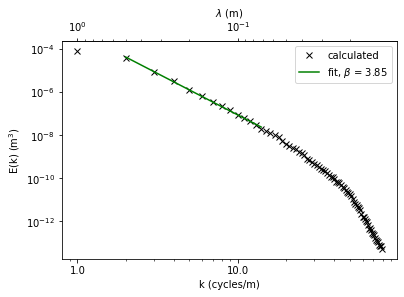

In [111]:
fig, ax = plot_MPS(S, k)
beta = fit_slope(S, k, k_max=14, i_min=2, fig=fig, ax=ax)
H = Hausdorff(beta, alpha, C1)
plt.show()
# slope should be -2

H = [0.61750713]


/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


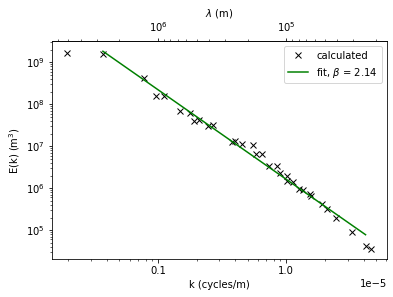

In [68]:

df = pd.read_csv('continents_logspectrum_m3.csv', header=None, names=['logk', 'logEk'], index_col=False, engine='python')
S = 10**(df['logEk'].to_numpy())
k = 10**(df['logk'].to_numpy())

fig, ax = plot_MPS(S, k)
beta = fit_slope(S, k, k_max=None, fig=fig, ax=ax)
H = Hausdorff(beta, alpha, C1)

In [162]:
def MHF(h, d):
    # mean haar fluctuations along a transect as function of length scale 2n
    # vector d is the distance in m from d0
    
    L_max = len(d)
    if np.mod(L_max, 2) > 0:
        L_max = L_max - 1  # must be even
#     print('L_max', L_max) # length of greatest L scale 2n
    
    MHF_L = []
    L = []
    for twon in range(L_max, 0, -2):
#         print('\n2n', twon)
        HF = []  # initialise Haar fluctuations at this L
        n = int(twon/2)
        r = n  # starting right edge of x1 such that r - n >= 0
        while r + 2 + n <= len(d):  # move wavelet along until right edge reaches end
#             print('r', r)
#             print('x1 [l:r]', r - n, ':', r + 1)
#             print('x2 [l:r]', r + 1, ':', r + 2 + n)
            
            x1 = h[r - n:r + 1] # first n points
            M1 = np.mean(x1)
            
            x2 = h[r + 1:r + 2 + n]  # last n points
            M2 = np.mean(x2)
            
#             print('x1', len(x1), 'x2', len(x2))
            HF.append(abs(M2 - M1))
            r = r + 1
        mean_HF = np.mean(HF)
        if not np.isnan(mean_HF):
            MHF_L.append(np.mean(HF))
            L.append(twon)
    return MHF_L, L  # mean haar fluctuation with each corresponding length scale


def MHF_grid(lat, lon, h, R, lon_res=20, lat_res=1):
    # planetary mean Haar fluctuations
    
    n_samples = len(lat)
    
    # convert latitude to metres from lat[0]
    arc_length = 2*np.pi*R/2 
    d = minmaxnorm(lat, a=0, b=arc_length)
    
    # subsample distance vector
    d = d[::lat_res]
    h = h[::lat_res,:]
    
    haars = []
    Ls = []
    for i in range(0, len(lon), lon_res):

        # take vertical N-S transects after Landais 2019
        hi = h[:,i]
        
        # calculate mean Haar fluctuations at each L along transect
        MHF_L, L = MHF(hi, d)
        haars.extend(MHF_L)
        Ls.extend(L)
#         if i == 0:
#             plt.figure()
#             plt.plot(L, MHF_L)
#             plt.ylabel('mean haar fluctuation')
#             plt.xlabel('distance scale')
            
#             plt.figure()
#             plt.plot(d, hi)
#             plt.ylabel('altitude')
#             plt.xlabel('distance from S pole')
    
    # sort and group
    df = pd.DataFrame({'L':Ls, 'MHF_L':haars})
    df = df.sort_values(by=['L'])
    df = df.groupby(['L']).mean()
    dL = d[1] - d[0]
    return df.index.to_numpy()*dL, df.MHF_L.to_numpy()

In [166]:
L, MHF_L = MHF_grid(lat, lon, h, R, lon_res=10, lat_res=10)

/home/claire/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/claire/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


H = 0.6901069337026676


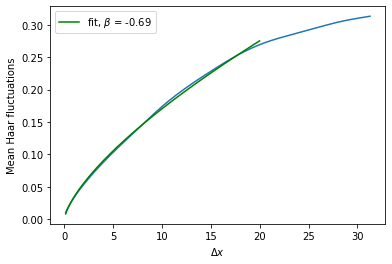

In [168]:
plt.plot(L, MHF_L)
plt.xlabel('$\Delta x$')
plt.ylabel('Mean Haar fluctuations')

beta = fit_slope(MHF_L, L, k_max=20, fig=plt.gcf(), ax=plt.gca(), i_min=0)
# slope should = H (because mean)
print('H =', -beta)

/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


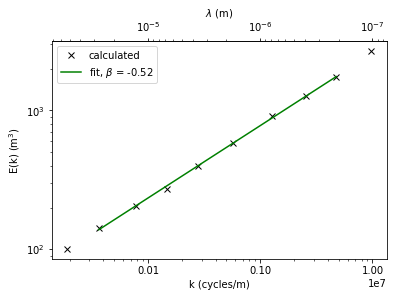

In [152]:
df = pd.read_csv('Mars_MHF_Landais.csv', header=None, names=['x', 'H'], index_col=False, engine='python')
H = df['H'].to_numpy()
L = df['x'].to_numpy()

fig, ax = plot_MPS(H, L)
beta = fit_slope(H, L, k_max=None, fig=fig, ax=ax)
# H = Hausdorff(beta, alpha, C1)